In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


## Data cleaning and exploration

In [2]:
# load data

df = pd.read_csv("UsArrests.csv", index_col="City")
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [3]:
# check for null values

df.isnull().sum()

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

No null/missing values, so no imputation required. Data type is float or int.

Now summarise the statistical properties of the columns:

In [4]:
# set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


Assault has the highest mean, max, and standard deviation, which is to be expected, as murder is less common than assault, and rapes are often not reported. These values are considerably higher than the other features, which suggests that scaling the data will be useful to stop this feature from skewing the analysis.

## Correlation Analysis

We can view the data and quickly ascertain if there are any correlations by using a pairplot to see features plotted against one another.

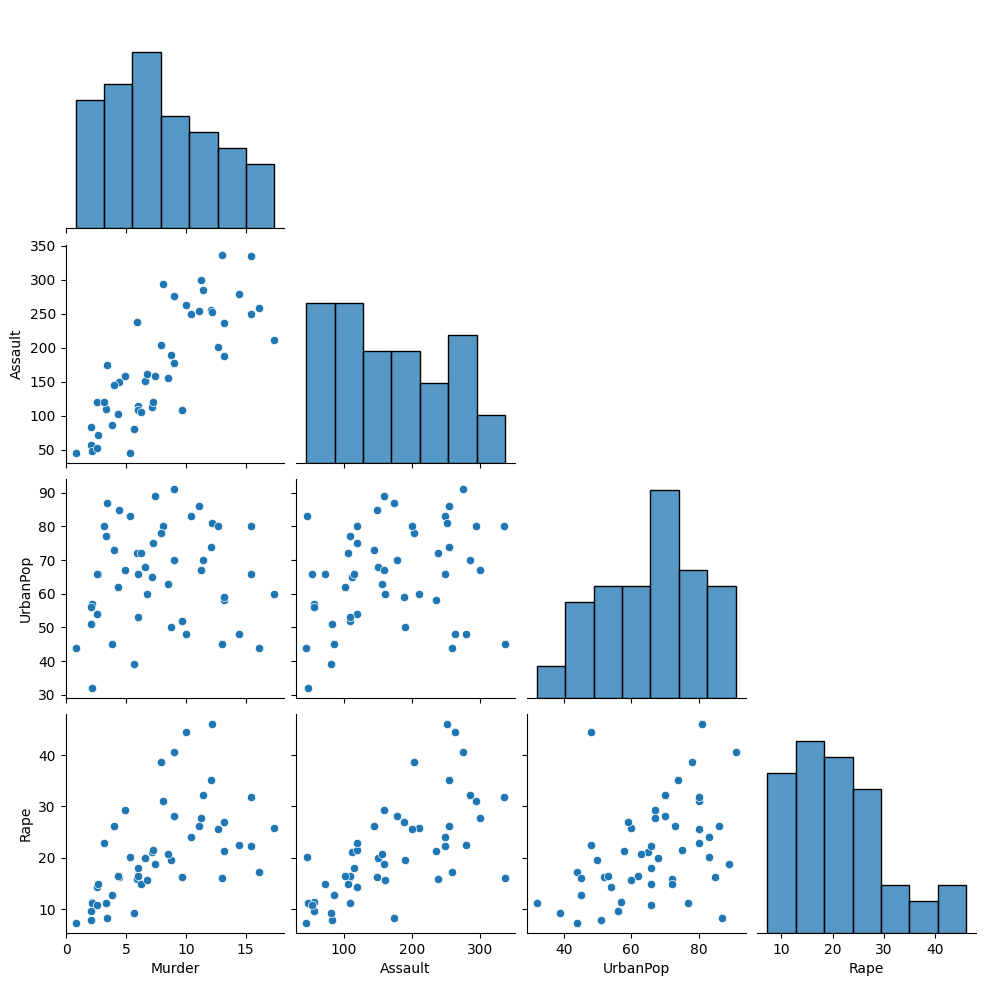

In [5]:
sns.pairplot(df, corner = True)

Most of the features seem to have at least a weakly positive correlation with one another, apart from urban population, where there appears to be perhaps no correlation at all with any other features. The only one which appears to have a weakly positive correlation with urban population is rape.

In [6]:
cities = df.index
corr_df = df.corr()
labels = corr_df.columns

<AxesSubplot:>

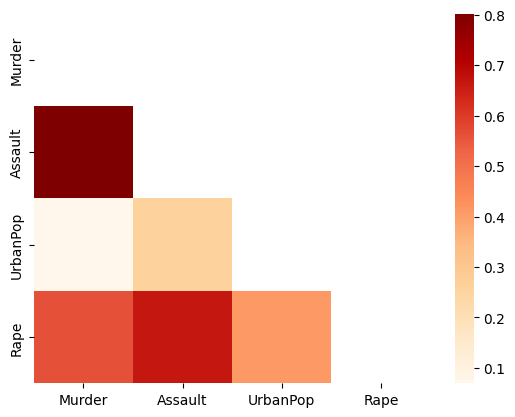

In [7]:
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool_)
sns.heatmap(corr_df, mask=mask_ut, cmap="OrRd")


This correlation heatmap corroborates the findings discussed above. Assault has the strongest correlations (with murder and rape). Rape also correlates quite strongly with murder. This is perhaps expected, as areas that are high in one type of crime are likely to be high in other types of crime.

We find that urban population tends to correlate more weakly than the other features. This means that this feature is a less reliable predictor of crime rates in the US.

## PCA

Principal Components Analysis is a useful way to reduce the dimensionality of an analysis. This dataset only contains 4 features, which isn't that many (relatively speaking) so reducing dimensionality isn't really an issue here. However, it can still be useful to find the principal components, given that we can determine the eigenvectors with the greatest variance.

In [8]:
# apply PCA

nr_comps = 4
pca = PCA(n_components=nr_comps)

X = df.values.squeeze()

# obtain components
X_trans = pca.fit_transform(X)

# transform the components into a pandas data frame
df_pca = pd.DataFrame(X_trans)

df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


In [9]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73240025 14.21240185  6.48942607  2.48279   ]


In [10]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.65534221e-01 2.78173366e-02 5.79953492e-03 8.48907879e-04]


In [11]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11485102 7213.10721735 7255.2198681  7261.38411429]


In [12]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

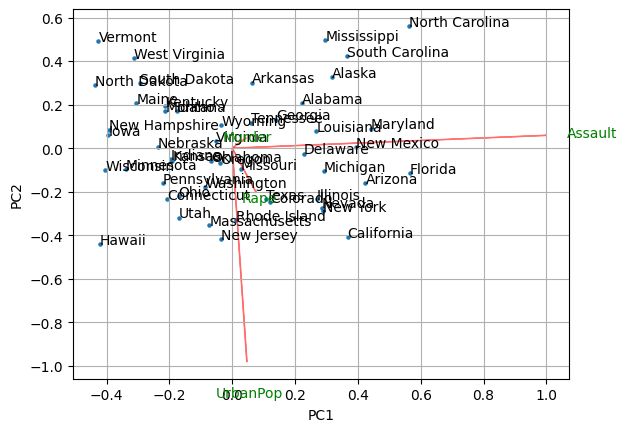

In [13]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(cities))
plt.show()

Can see that PC1 is dominated by Assault, while PC2 is dominated by urban population. Given that assault is much larger than the other values, it makes it difficult to read the data points separately, so we need to standardise the data.

In [14]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

# components
pc1 = abs( pca.components_[0] ) 
pc2 = abs( pca.components_[1] )
pc3 = abs( pca.components_[2] )
pc4 = abs( pca.components_[3] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df["PC3 Importance"] = pc3
feat_df["PC4 Importance"] = pc4
feat_df

,Features,PC1 Importance,PC2 Importance,PC3 Importance,PC4 Importance
0,Murder,0.042,0.045,0.080,0.995
1,Assault,0.995,0.059,0.068,0.039
2,UrbanPop,0.046,0.977,0.201,0.058
3,Rape,0.075,0.201,0.974,0.072


As seen in the biplot, Assault dominates PC1 (with almost no contribution from the rest of the features) while UrbanPop dominates PC2. We also see that Rape is the second highest feature for PC2, and additionally is the main contributing feature for PC3. Lastly, Murder contributes very little least to all PCs, except to PC4 (where it completely dominates).

## Standardised data

We standardise the data so that for a better spread of features and data points.

In [15]:
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


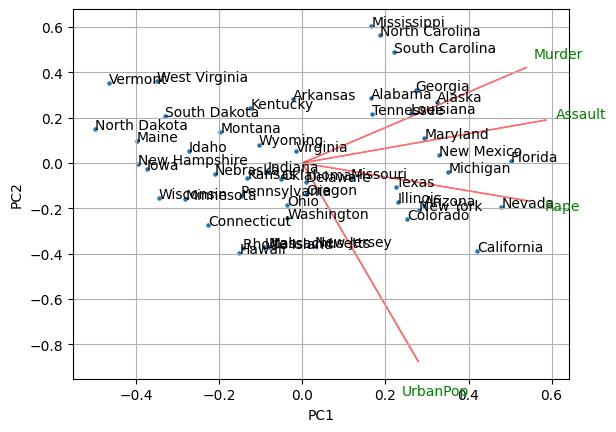

In [16]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

Can see that the features are more spread out between PC1 and PC2, and that there is now a better spread across the data.

In [17]:
# Feature importance

pc1 = abs( std_pca.components_[0] )
pc2 = abs( std_pca.components_[1] )
pc3 = abs( std_pca.components_[2] )
pc4 = abs( std_pca.components_[3] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df["PC3 Importance"] = pc3
feat_df["PC4 Importance"] = pc4
feat_df

,Features,PC1 Importance,PC2 Importance,PC3 Importance,PC4 Importance
0,Murder,0.536,0.418,0.341,0.649
1,Assault,0.583,0.188,0.268,0.743
2,UrbanPop,0.278,0.873,0.378,0.134
3,Rape,0.543,0.167,0.818,0.089


The feature importance has changed significantly with the standardised data. Murder, Assault, and Rape all no contribute almost evenly to PC1, and UrbanPop contributes significantly as well. With PC2, the distribution is not as even, but all features still contribute significantly. 

Text(0.5, 1.0, 'Cumulative Explained Variance')

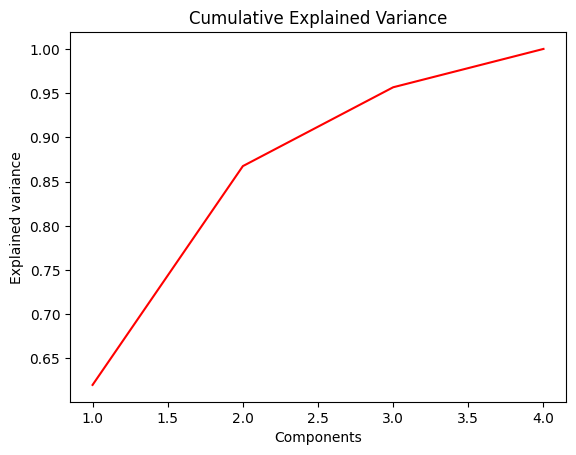

In [18]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

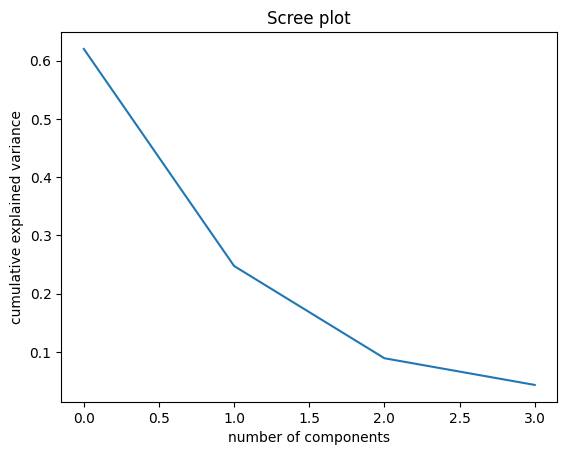

In [19]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 2 principal components together explain almost 90% of the variance, and the first 3 over 95%. While there were only 4 features to begin with, which is a relatively low number, we can reduce the problem to 2 or 3 dimensions.

In [20]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
City,,,
Alabama,0.986,1.133,-0.444
Alaska,1.950,1.073,2.040
Arizona,1.763,-0.746,0.055
Arkansas,-0.141,1.120,0.115
California,2.524,-1.543,0.599


## Hierarchical clustering

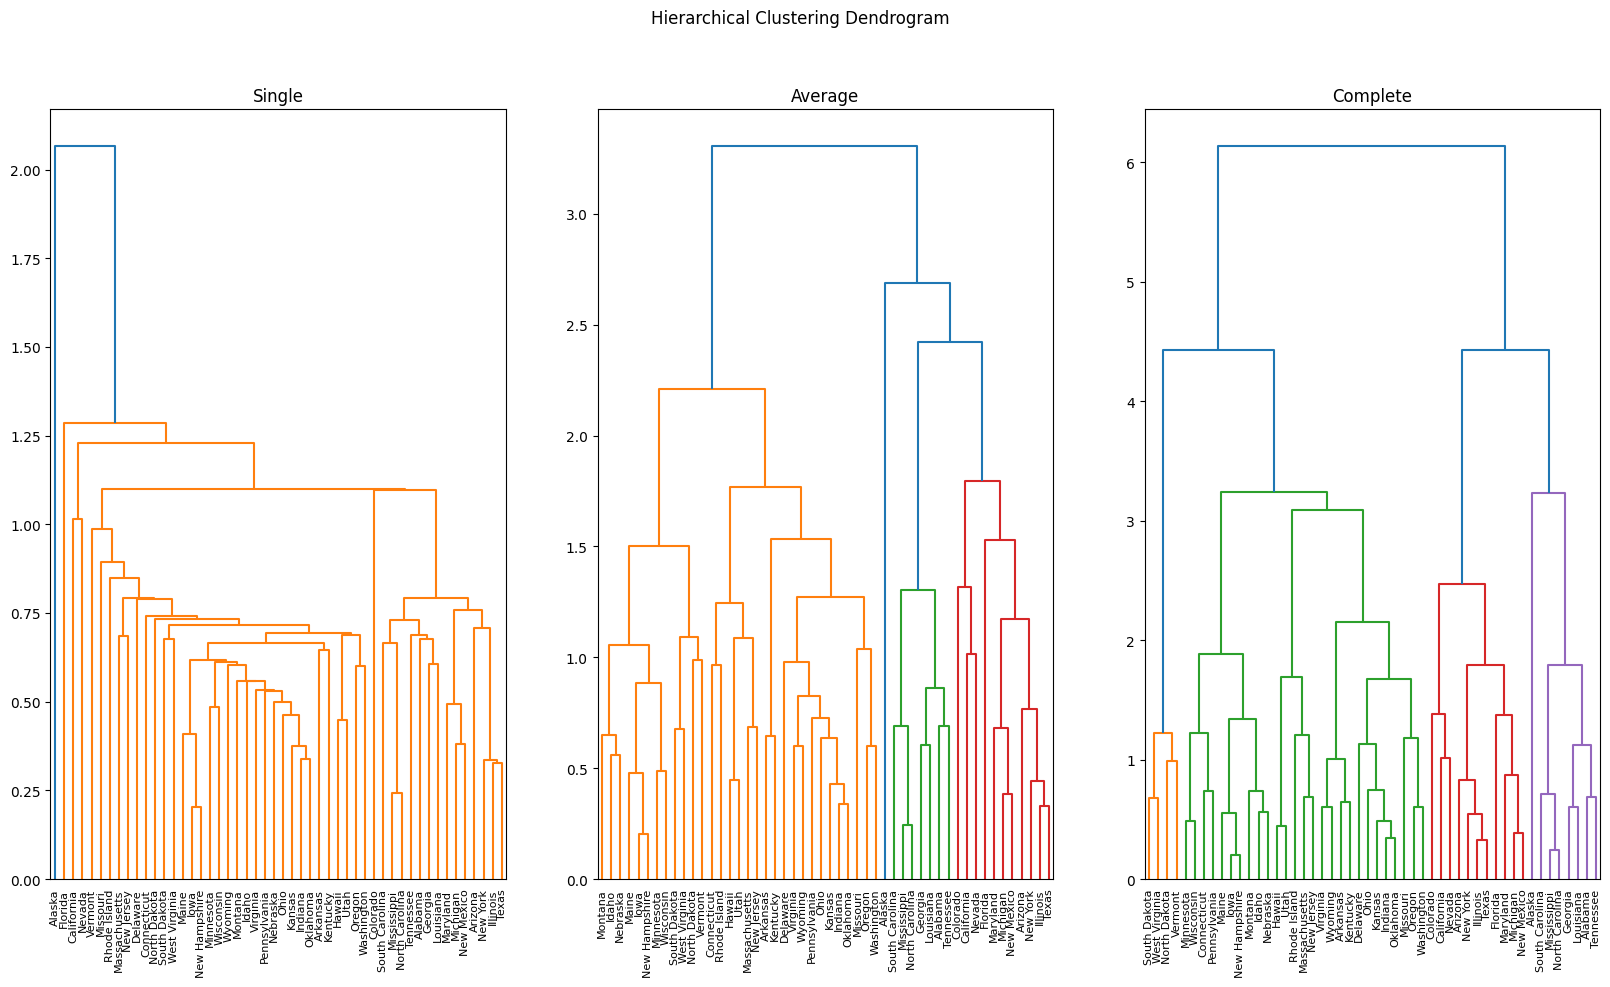

In [21]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,10))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

The complete linkage seems to give better clusters, so we will replot this for clarity:

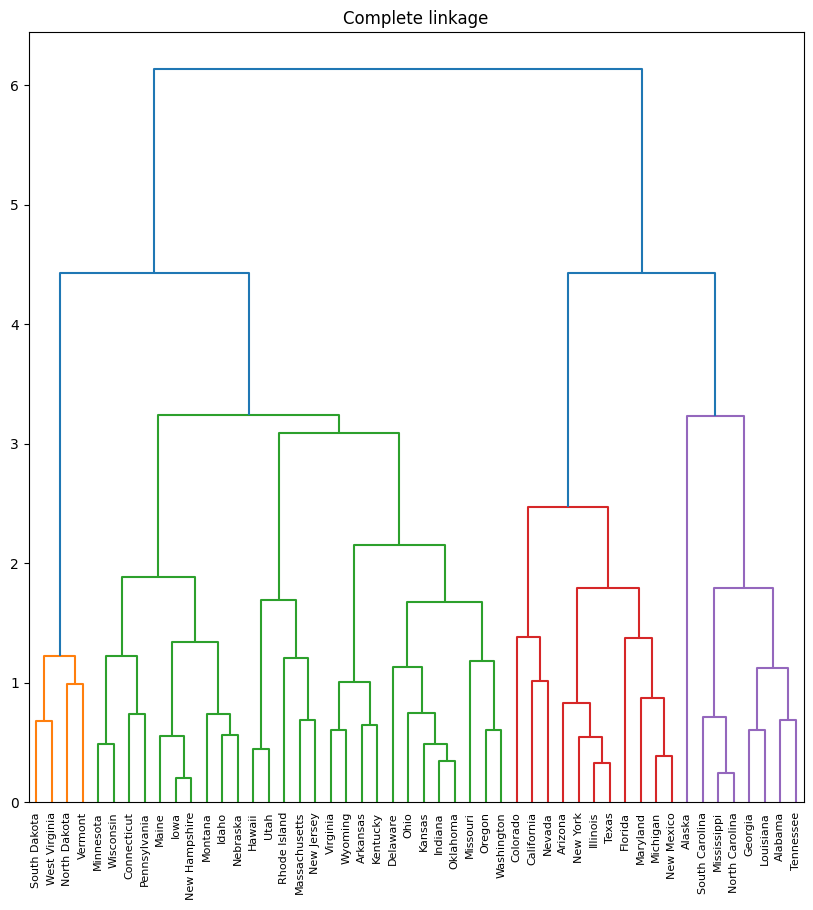

In [22]:
plt.figure(figsize=(10,10))
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

We can see from the dendrogram that we can cut the branches to have four reasonably defined clusters. We will use this information in the K-means clustering algorithm below.

## K-means clustering

Text(0, 0.5, 'Dim 1')

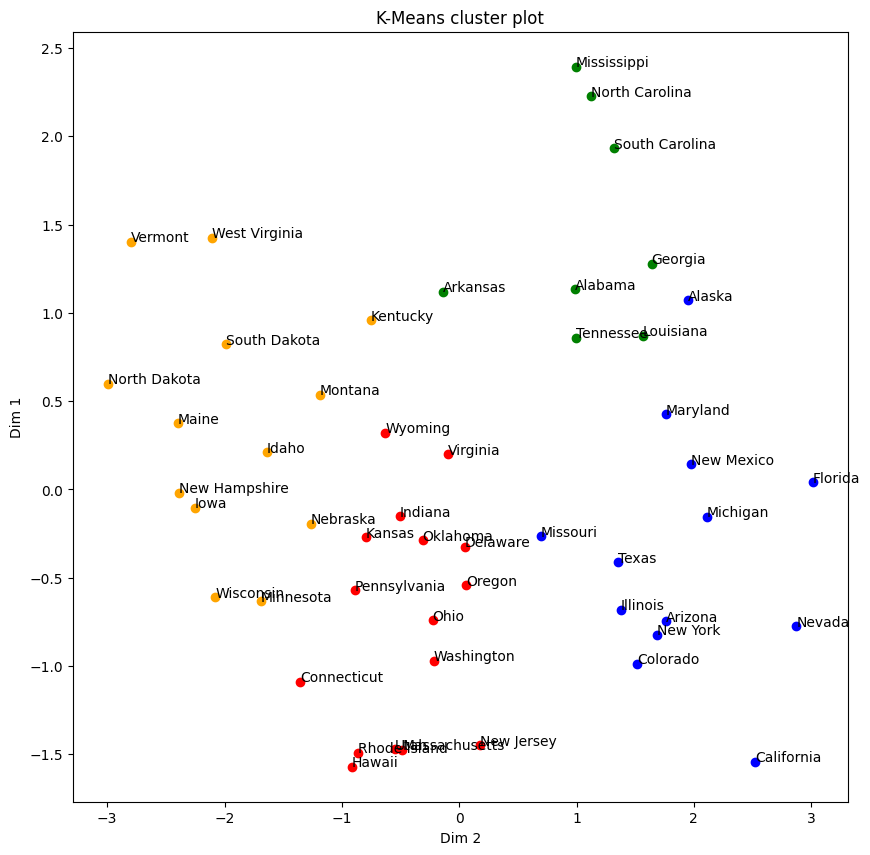

In [23]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots(figsize=(10,10))
colours = ['red','green','blue','orange']
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

The clusters here are not incredibly obvious, but we can look for trends within clusters by using a map.

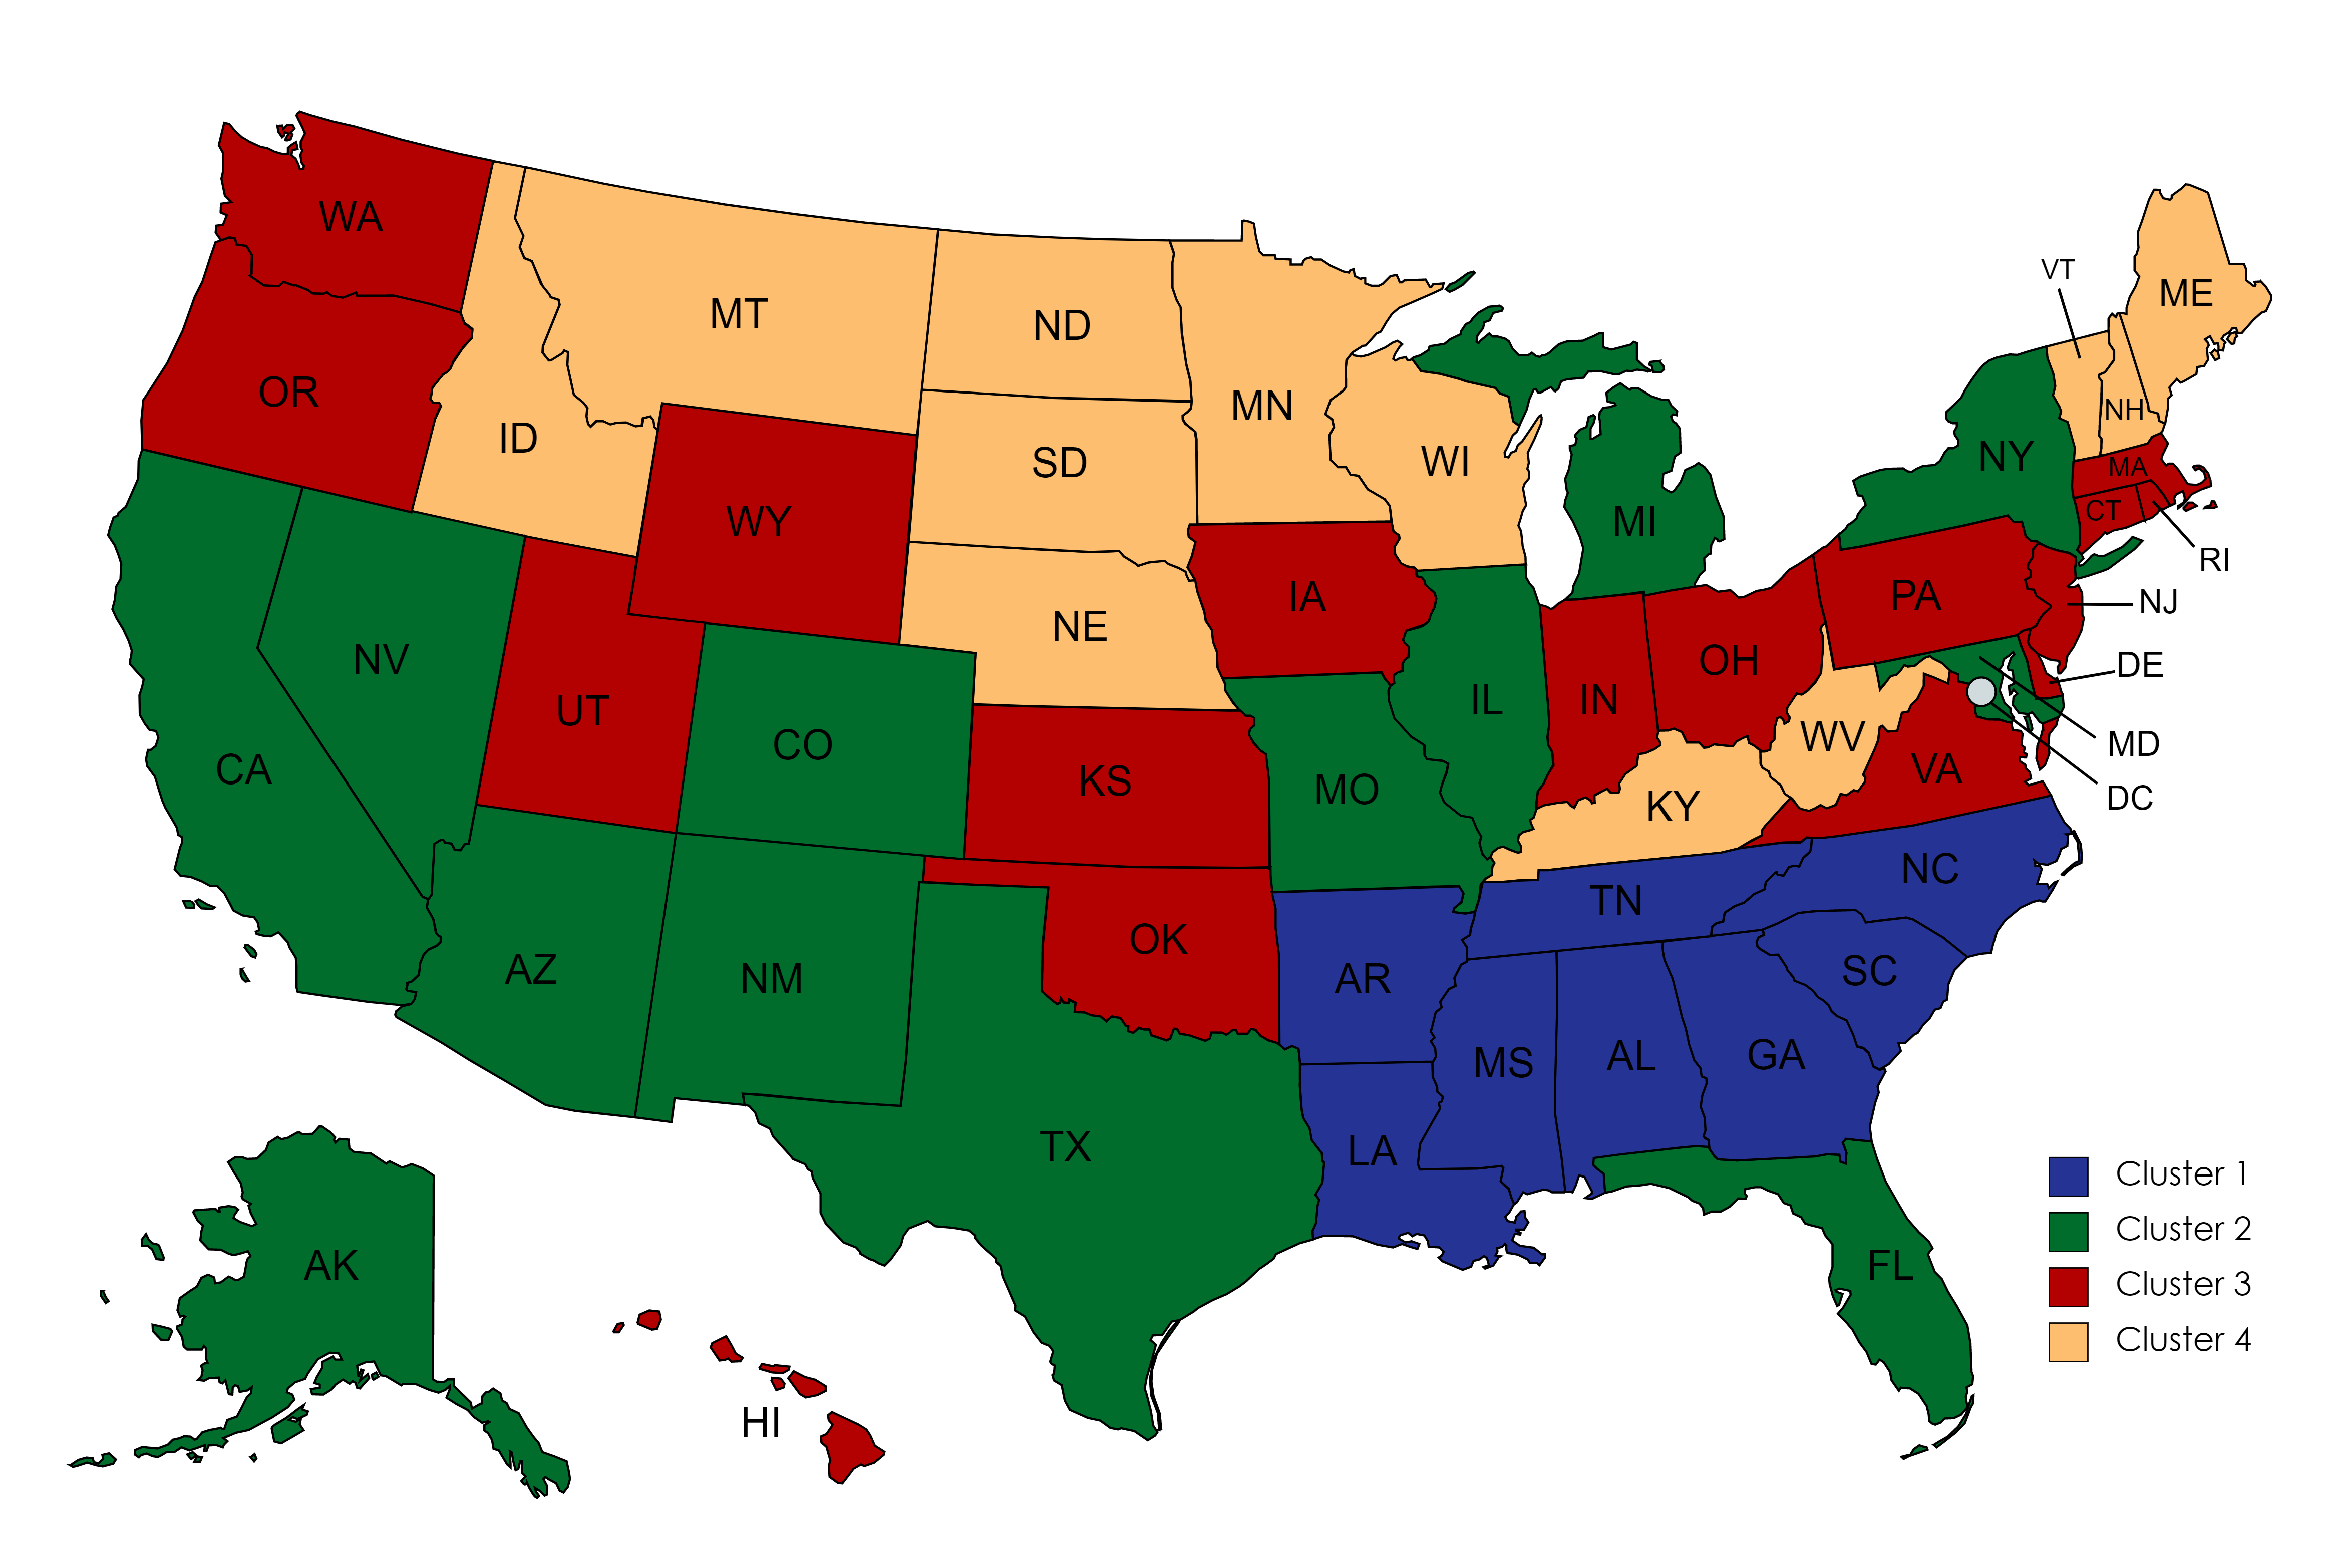

In [24]:
from PIL import Image
cluster_map = Image.open("MapChart.png")
display(cluster_map)

We see that Cluster 1 (blue) comprises the south-east states, with the exception of Florida.  Cluster 2 (green) mainly comprises the south-west states, with some exceptions on the east cost. Cluster 4 (orange) is mainly the north-west states, with a few exceptions, and Cluster 3 doesn't have any obvious similarities between states.

We can try having 2 clusters rather than 4, as this would also be supported by the dendrogram.

Text(0, 0.5, 'Dim 1')

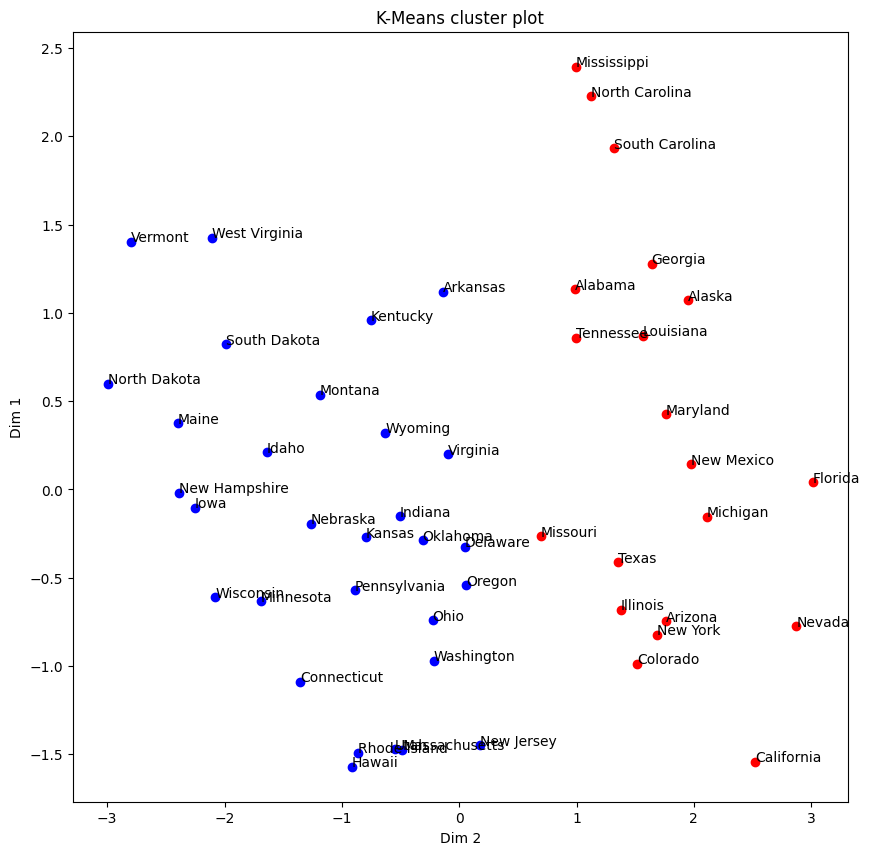

In [25]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots(figsize=(10,10))
colours = ['blue','red']
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

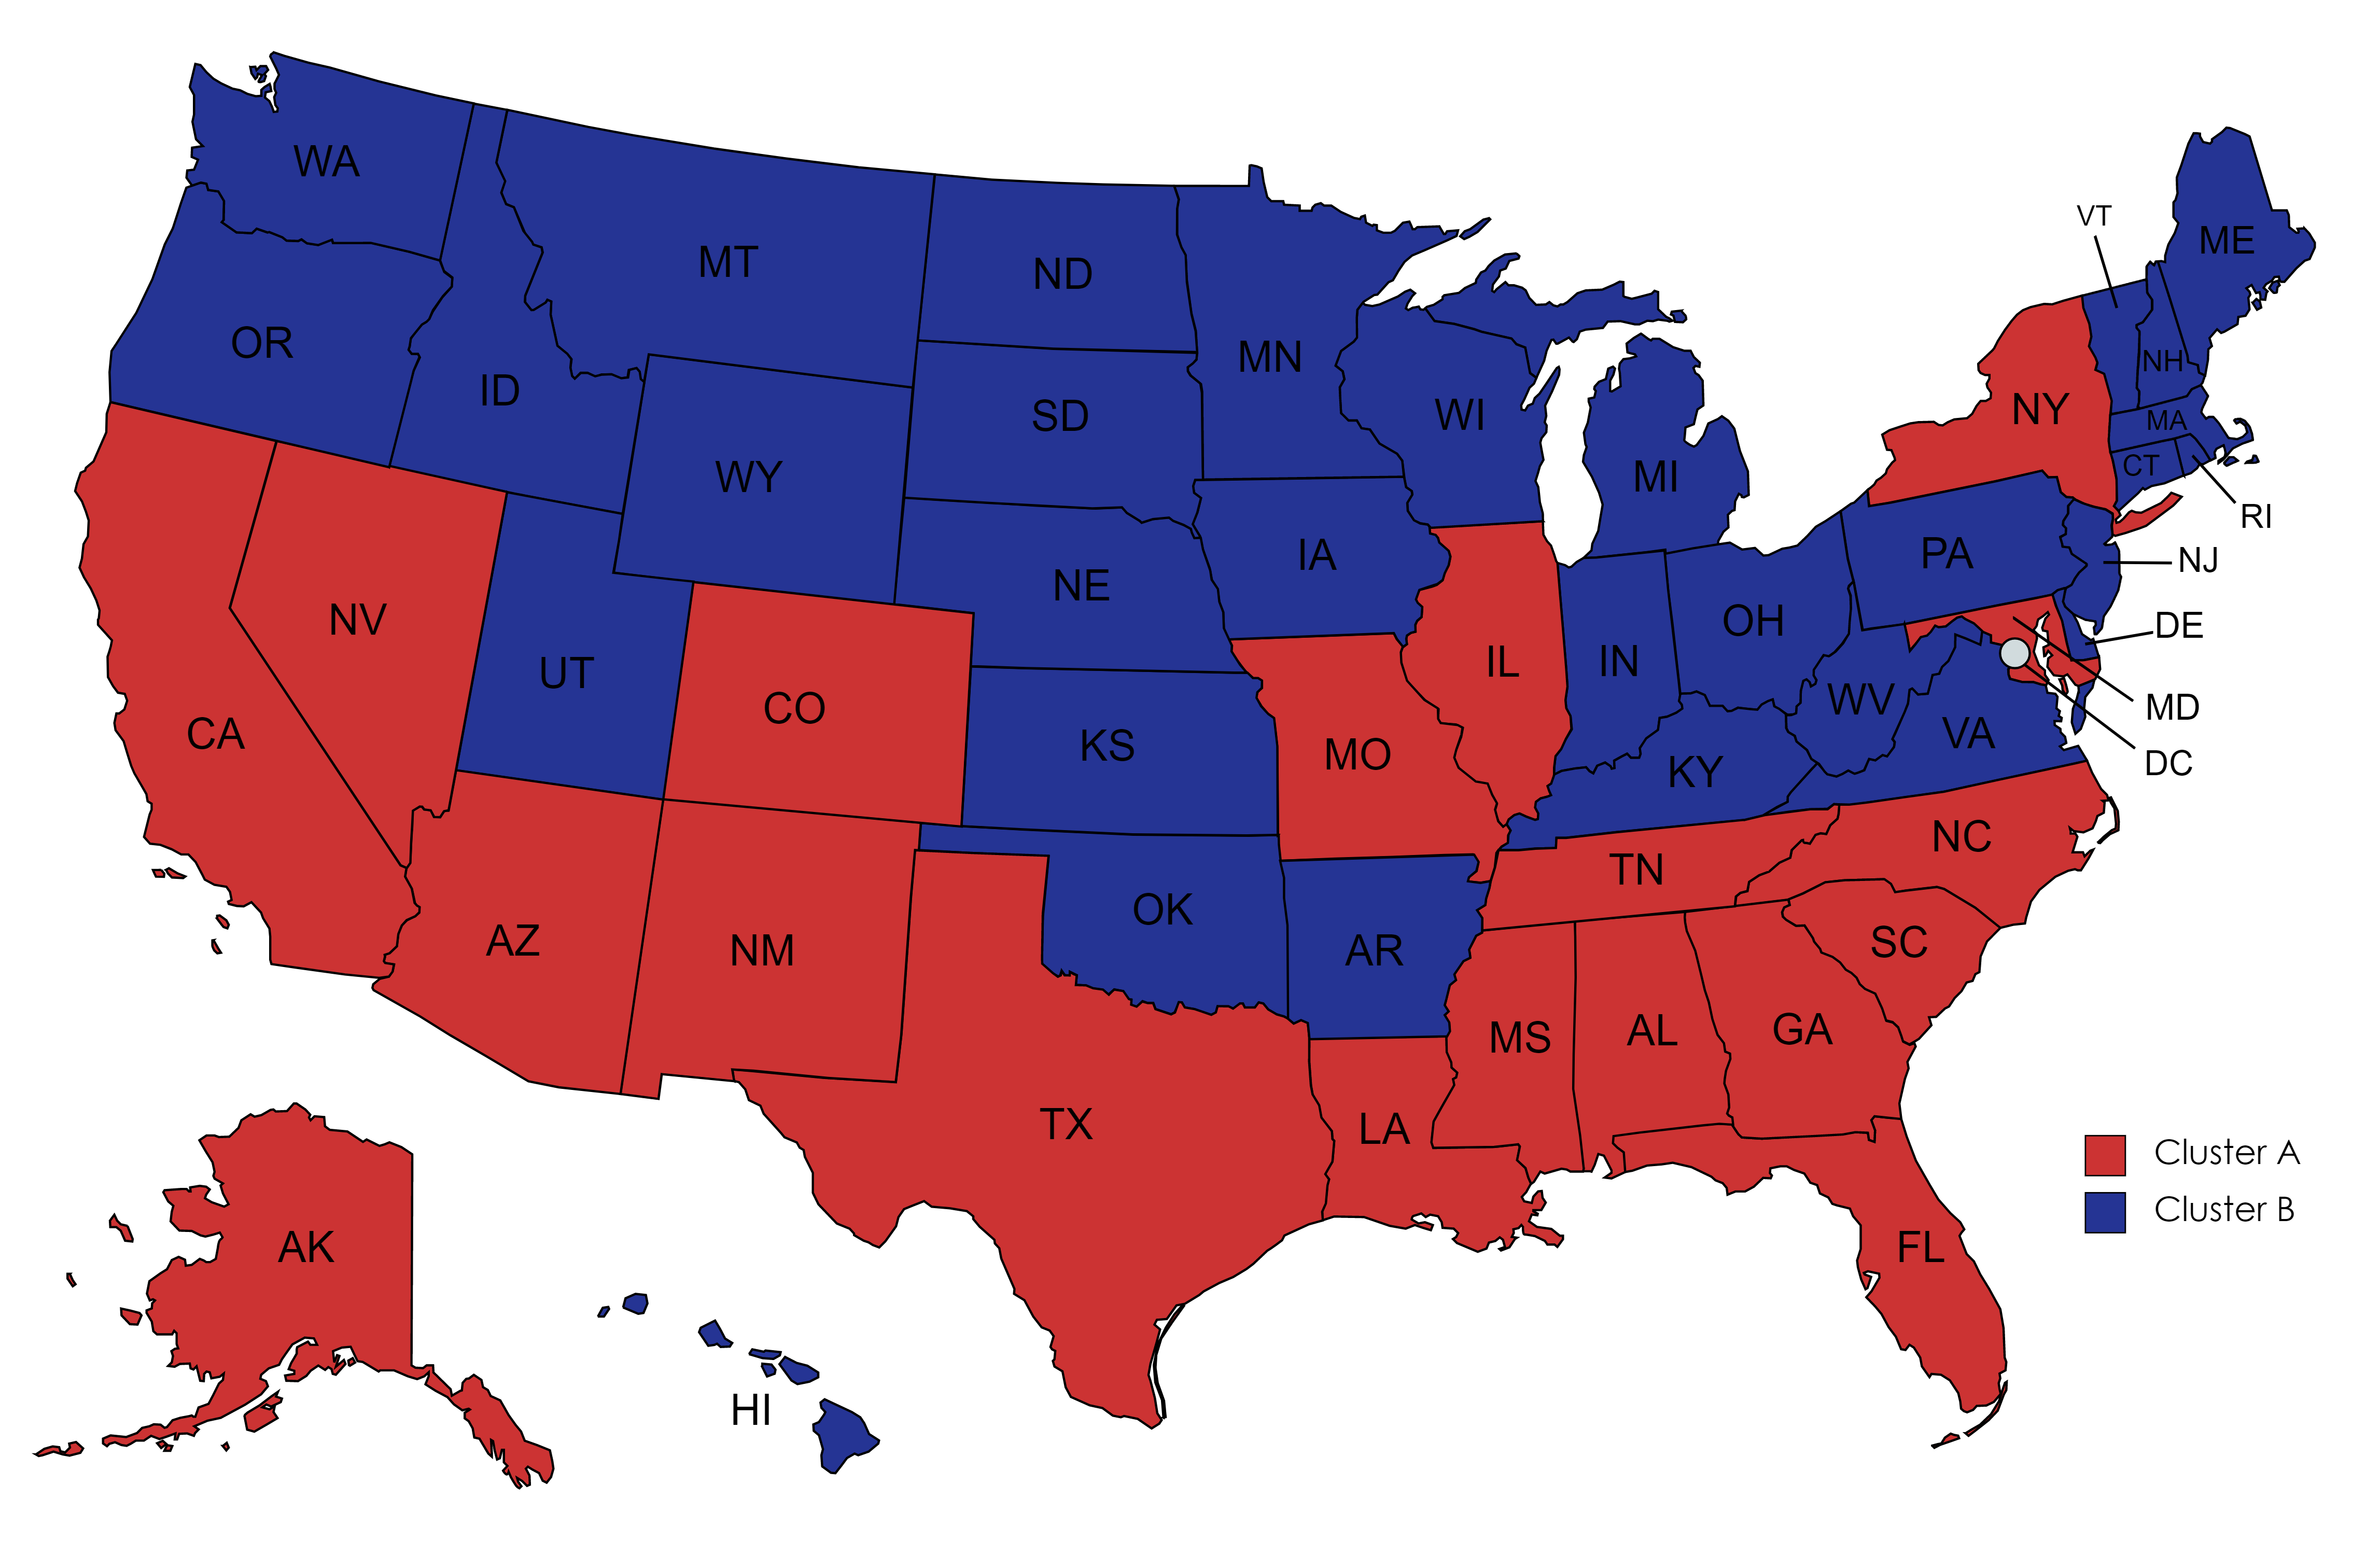

In [26]:
cluster_map_2 = Image.open("MapChart2.png")
display(cluster_map_2)

Here it's easier to see the differences between the clusters; in general Cluster A (red) comprises the southern states, with notable exceptions of New York and Maryland, while Cluster B (blue) comprises mainly the northern states. 

Looking at the biplot, it seems that Cluster A correlates to higher murder, assault, and rape rates, and vice versa for Cluster B. Given the political history of the southern states, as well as the important northern states New York and Maryland, this is perhaps to be expected (particularly given that this data is taken from the year 1973).